# Fiber Assignment

This tutorial will teach you:
* The required inputs to fiber assignment.
* How to run `fiberassign` on those.
* How to interpret the fiber assignment output files, including understanding coverage.

Note: this tutorial requires the fiberassign *master* branch.

Stephen Bailey<br/>
January 2019

## Basic python imports

In [1]:
%pylab inline
import os, sys, subprocess
from collections import Counter

import numpy as np
from astropy.table import Table
from astropy.io import fits

import desimodel.io
import desimodel.focalplane
import desimodel.footprint
from desitarget.targetmask import desi_mask, obsconditions

Populating the interactive namespace from numpy and matplotlib


## Create an output directory in $SCRATCH/desi/test/fiberassign

In [2]:
workdir = os.getenv('SCRATCH') + '/desi/test/fiberassign'
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)
outdir = workdir + '/output'
os.makedirs(outdir, exist_ok=True)

# Fiber Assignment inputs

Fiber assignment requires the following input files:

**TODO**: document what each column is
    
* "Merged Target List" (MTL): FITS file with columns:
  * TARGETID
  * RA
  * DEC
  * DESI_TARGET
  * BGS_TARGET
  * MWS_TARGET
  * PRIORITY
  * SUBPRIORITY
  * BRICKNAME
  * OBSCONDITIONS
  * NUMOBS_MORE
* sky locations; FITS file with columns:
  * TARGETID
  * RA
  * DEC
  * DESI_TARGET
  * BGS_TARGET
  * MWS_TARGET
  * PRIORITY
  * SUBPRIORITY
  * BRICKNAME
  * OBSCONDITIONS

Standard stars can either be in the same file as the science targets, or they can
be in a separate file (with the same required columns).  `fiberassign` uses `DESI_TARGET`
mask bits `STD_FAINT`, `STD_BRIGHT`, and `STD_WD` to determine which targets may be
used as standard stars.

Optional inputs:

* footprint tiles (default `$DESIMODEL/data/footprint/desi-tiles.fits`) with columns
  * TILEID
  * RA
  * DEC
  * PASS
  * OBSCONDITIONS
  * IN_DESI
  * PROGRAM



# Fiber Assignment from scratch

First we'll run fiberassignment on a set of random targets and tiles to understand the required inputs.  Then we'll proceed with running it on real data for real DESI tile locations.

## Custom tiling

We'll start by generting a set of offset tiles

In [3]:
ntiles = 5
tiles = Table()
tile_radius = desimodel.focalplane.get_tile_radius_deg()
tiles['TILEID'] = np.arange(ntiles, dtype='i4')
tiles['RA'] = 2 + np.arange(ntiles)*0.5*tile_radius
tiles['DEC'] = np.zeros(ntiles)
tiles['PASS'] = np.zeros(ntiles, dtype='i2')
tiles['OBSCONDITIONS'] = np.ones(ntiles, dtype='i4') * obsconditions.DARK
tiles['IN_DESI'] = np.ones(ntiles, dtype='i2')
tiles['PROGRAM'] = np.full(ntiles, 'DARK', dtype='S6')
tiles.write('tiles.fits', format='fits', overwrite=True)

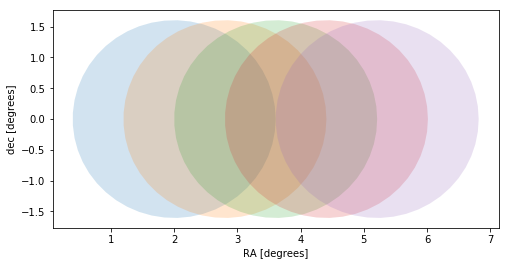

In [4]:
def plot_sky_circle(x, y, radius, alpha=0.2):
    theta = np.linspace(0, 2*np.pi, 50)
    xx = x + np.cos(np.radians(y))*radius*np.cos(theta)
    yy = y + radius*np.sin(theta)
    fill(xx, yy, alpha=alpha)

def plot_tile(ra, dec, alpha=0.2):
    tile_radius = desimodel.focalplane.get_tile_radius_deg()
    plot_sky_circle(ra, dec, tile_radius)

def plot_tiles(tiles):
    for i in range(len(tiles)):
        plot_tile(tiles['RA'][i], tiles['DEC'][i])
    xlabel('RA [degrees]')
    ylabel('dec [degrees]')

figure(figsize=(8,4))
plot_tiles(tiles)

Let's compare that tiling coverage to the fiber coverage.  We'll see that the coverage of
actual fibers (positioners) is less than that of the tile, and has a more complex spatial structure.

Text(0,0.5,'dec [degrees]')

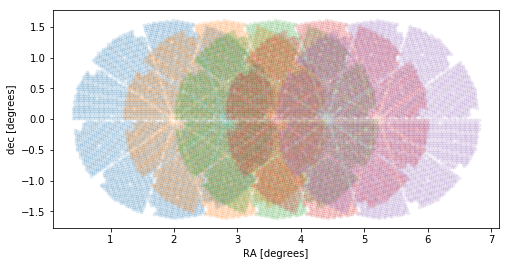

In [5]:
def plot_positioners(tilera, tiledec, alpha=0.1):
    fiberpos = desimodel.io.load_fiberpos()
    ra, dec = desimodel.focalplane.xy2radec(tilera, tiledec, fiberpos['X'], fiberpos['Y'])
    plot(ra, dec, '.', alpha=alpha)

figure(figsize=(8,4))
for i in range(len(tiles)):
    plot_positioners(tiles['RA'][i], tiles['DEC'][i])

xlabel('RA [degrees]')
ylabel('dec [degrees]')

## Random targets

Now we'll generate randomly distributed targets.  To facilitate counting, we'll trim those
to just targets that are potentially covered by a tile (but might still not be covered by
any fibers)

In [6]:
def generate_random_targets(density, tiles):
    #- Get basic bounds; don't worry about RA wraparound for this example
    tile_radius = desimodel.focalplane.get_tile_radius_deg()
    ramin = np.min(tiles['RA'] - tile_radius*np.cos(np.radians(tiles['DEC'])))
    ramax = np.max(tiles['RA'] + tile_radius*np.cos(np.radians(tiles['DEC'])))
    decmin = np.min(tiles['DEC']) - tile_radius
    decmax = np.max(tiles['DEC']) + tile_radius
    
    area = (ramax-ramin) * np.degrees((np.sin(np.radians(decmax)) - np.sin(np.radians(decmin))))
    n = int(area*density)

    #- Iterate if needed to get unique TARGETIDs
    while True:
        targetids = np.random.randint(0, 2**62-1, n)
        if len(set(targetids)) == n:
            break

    #- Create targets table
    targets = Table()
    targets['TARGETID'] = targetids
    targets['RA'] = np.random.uniform(ramin, ramax, n)
    phimin = np.radians(90-decmin)
    phimax = np.radians(90-decmax)
    targets['DEC'] = 90-np.degrees(np.arccos(np.random.uniform(np.cos(phimin), np.cos(phimax), n)))
    targets['DESI_TARGET'] = np.zeros(n, dtype='i8')
    targets['BGS_TARGET'] = np.zeros(n, dtype='i8')
    targets['MWS_TARGET'] = np.zeros(n, dtype='i8')
    targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
    targets['BRICKNAME'] = np.full(n, '000p0000')    #- required !?!
    
    #- Trim to targets that are covered by a tile
    ii = desimodel.footprint.is_point_in_desi(tiles, targets['RA'], targets['DEC'])
    targets = targets[ii]
    
    return targets


In [7]:
#- ELG-like sample: high density, only one requested observation per target
density = 2400
targets = generate_random_targets(density, tiles)
n = len(targets)
targets['PRIORITY'] = 1000
targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
targets['DESI_TARGET'] = desi_mask.ELG
targets['OBSCONDITIONS'] = np.ones(n, dtype='i4') * obsconditions.DARK
targets['NUMOBS_MORE'] = np.ones(n)
targets.meta['EXTNAME'] = 'MTL'
targets.write('mtl.fits', overwrite=True)

In [8]:
#- Sky targets at 4x the density of fibers
fiber_density = 5000 / 7.5
sky_density = 4*fiber_density
sky = generate_random_targets(sky_density, tiles)
nsky = len(sky)
sky['DESI_TARGET'] = desi_mask.SKY
sky['OBSCONDITIONS'] = np.ones(nsky, dtype='i4') * obsconditions.mask('DARK|GRAY|BRIGHT')
sky.meta['EXTNAME'] = 'SKY'
sky.write('sky.fits', overwrite=True)

In [9]:
std_density = 50
stdstars = generate_random_targets(std_density, tiles)
nstd = len(stdstars)
stdstars['SUBPRIORITY'] = np.random.uniform(0, 1, nstd)
stdstars['DESI_TARGET'] = desi_mask.STD_FAINT
stdstars['OBSCONDITIONS'] = np.ones(nstd, dtype='i4') * obsconditions.DARK
stdstars.meta['EXTNAME'] = 'STD'
stdstars.write('stdstars.fits', overwrite=True)

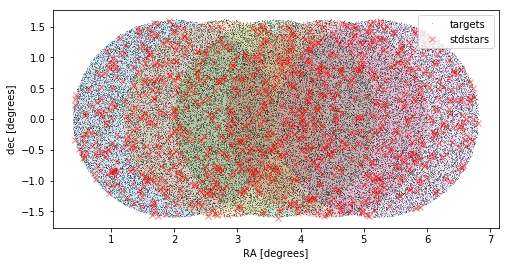

In [10]:
figure(figsize=(8,4))
plot(targets['RA'], targets['DEC'], 'k,', alpha=0.3, label='targets')
plot(stdstars['RA'], stdstars['DEC'], 'rx', alpha=0.5, label='stdstars')
plot_tiles(tiles)
legend()

## Run fiberassign on those targets/standards/sky

In [11]:
cmd = 'fiberassign --mtl mtl.fits --stdstar stdstars.fits --sky sky.fits'
cmd += ' --footprint ./tiles.fits'
cmd += ' --outdir ./output/'
cmd = cmd.format(outdir=outdir)
# print('cd ' + workdir)
# print(cmd)

In [12]:
#- Cleanup old files if needed; support several generations of file names
def cleanup_output(outdir, tiles):
    outfiles = list()
    for tileid in tiles['TILEID']:
        outfiles.append('{}/tile_{:05d}.fits'.format(outdir, tileid))
        outfiles.append('{}/tile-{:05d}.fits'.format(outdir, tileid))
        outfiles.append('{}/fiberassign_{:05d}.fits'.format(outdir, tileid))
        outfiles.append('{}/fiberassign-{:05d}.fits'.format(outdir, tileid))

    for filename in outfiles:
        if os.path.exists(filename):
            os.remove(filename)
            
cleanup_output(outdir, tiles)
            
#- TODO: capture stderr/stdout to a log
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

RUNNING: fiberassign --mtl mtl.fits --stdstar stdstars.fits --sky sky.fits --footprint ./tiles.fits --outdir ./output/
0


## fiberassign output

`fiberassign` output files contain the following HDUs:
* `FIBERASSIGN`: fiber assignments for the 5000 positioners with fibers connected to a spectrograph
* `POTENTIAL_ASSIGNMENTS`: a table of what targets were covered by what fibers, whether or not they were assigned
* `SKYETC`: assignments of the 20 fibers that go to the sky monitor camera (not the spectrographs)
* `TARGETS`: (deprecated) a copy of the input targets table with all columns

In [13]:
tilefile = '{}/tile-{:05d}.fits'.format(outdir, tiles['TILEID'][0])
fx = fits.open(tilefile)
print(fx.info())
print('\nFIBERASSIGN columns:')
print(fx['FIBERASSIGN'].data.dtype.names)
print('\nPOTENTIAL_ASSIGNMENTS columns:')
print(fx['POTENTIAL_ASSIGNMENTS'].data.dtype.names)
fx.close()

Filename: /global/cscratch1/sd/sjbailey/desi/test/fiberassign/output/tile-00000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  FIBERASSIGN    1 BinTableHDU     61   5000R x 23C   [J, J, I, J, K, K, K, K, D, D, E, E, 8A, J, E, E, E, 3A, I, J, D, J, D]   
  2  SKY_MONITOR    1 BinTableHDU     45   20R x 18C   [J, J, I, J, K, K, K, K, D, D, E, E, 8A, J, E, E, I, J]   
  3  TARGETS       1 BinTableHDU     31   5000R x 11C   [K, D, D, K, K, K, D, 8A, K, J, D]   
  4  POTENTIAL_ASSIGNMENTS    1 BinTableHDU     15   41820R x 3C   [K, J, J]   
None

FIBERASSIGN columns:
('FIBER', 'LOCATION', 'NUMTARGET', 'PRIORITY', 'TARGETID', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'TARGET_RA', 'TARGET_DEC', 'DESIGN_X', 'DESIGN_Y', 'BRICKNAME', 'FIBERSTATUS', 'DESIGN_Q', 'DESIGN_S', 'LAMBDA_REF', 'OBJTYPE', 'PETAL_LOC', 'DEVICE_LOC', 'SUBPRIORITY', 'OBSCONDITIONS', 'NUMOBS_MORE')

POTENTIAL_ASSIGNMENTS columns:
('TARGETID', 'FIBER

## Which targets were assigned?

In [14]:
assignments = list()
for tileid in tiles['TILEID']:
    tilefile = '{}/tile-{:05d}.fits'.format(outdir, tileid)
    assignments.append(Table.read(tilefile, 'FIBERASSIGN'))

In [15]:
assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
isAssigned = np.in1d(targets['TARGETID'], assigned_targetids)

Text(0.5,1,'Targets assigned to fibers')

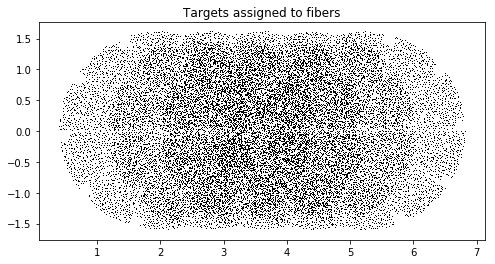

In [16]:
figure(figsize=(8,4))
plot(targets['RA'][isAssigned], targets['DEC'][isAssigned], 'k,')
title('Targets assigned to fibers')
# plot_tiles(tiles)

## And which targets weren't assigned?

Text(0.5,1,'Targets not assigned to fibers')

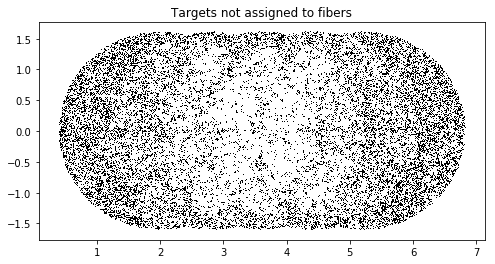

In [17]:
figure(figsize=(8,4))
plot(targets['RA'][~isAssigned], targets['DEC'][~isAssigned], 'k,')
title('Targets not assigned to fibers')

Let's compare the number that were assigned to the simple estimate of counting fibers.
For this density of targets, nearly all fibers are assigned to a target.
i.e. if a target wasn't assigned, it was because either it wasn't covered by a fiber at all,
or because that fiber was given to a different target instead.  Good.

In [18]:
num_assigned = np.count_nonzero(isAssigned)
max_possible_assigned = int(len(tiles) * 5000 * 0.9)  #- 10% of fibers are reserved for std and sky calibrators
print('Targets assigned        ', num_assigned)
print('Max possible assignments', max_possible_assigned)
print('Ratio                   ', num_assigned/max_possible_assigned)

Targets assigned         22315
Max possible assignments 22500
Ratio                    0.9917777777777778


# Assigning a target more than once - part I

Now let's make a sample like Survey Validation, with a high target density but requesting 4 assignments per target when possible (`NUMOBS_MORE = 4`)

In [19]:
#- Science Verification sample: high density, with multiple requested observations per target
density = 2400
targets = generate_random_targets(density, tiles)
n = len(targets)
targets['PRIORITY'] = 1000
targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
targets['DESI_TARGET'] = desi_mask.ELG
targets['OBSCONDITIONS'] = np.ones(n) * obsconditions.DARK
targets['NUMOBS_MORE'] = np.ones(n) * 4  #- THIS IS WHAT IS DIFFERENT THAN BEFORE
targets.meta['EXTNAME'] = 'MTL'
targets.write('mtl.fits', overwrite=True)

In [20]:
#- Rerun fiberassign
cleanup_output(outdir, tiles)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

0


### Histogram how many times each target was assigned

In [21]:
def get_assigned_covered(tiles):
    assigned_ids = list()
    covered_ids = list()
    for tileid in tiles['TILEID']:
        tilefile = '{}/tile-{:05d}.fits'.format(outdir, tileid)
        assignments = Table.read(tilefile, 'FIBERASSIGN')
        assigned_ids.extend(assignments['TARGETID'])

        #- Note: a single target could be covered by more than one fiber on the same
        #- tile, but it still can only be assigned once, so use np.unique() per tile
        #- to not double count those cases
        potential = Table.read(tilefile, 'POTENTIAL_ASSIGNMENTS')
        covered_ids.extend(np.unique(potential['TARGETID']))

    #- Trim to just science targets (i.e. not SKY, not non-science STDSTAR)
    assigned_ids = np.array(assigned_ids)
    ii = np.in1d(assigned_ids, targets['TARGETID'])
    assigned_ids = assigned_ids[ii]

    covered_ids = np.array(covered_ids)
    ii = np.in1d(covered_ids, targets['TARGETID'])
    covered_ids = covered_ids[ii]

    return assigned_ids, covered_ids

#- Do a bit of counting magic to include targets that were never assigned or covered
def count_coverage(ids):
    c = Counter(ids)
    c.update(targets['TARGETID'])
    count = np.array(list(c.values())) - 1
    return count

In [22]:
assigned_ids, covered_ids = get_assigned_covered(tiles)
assigned_count = count_coverage(assigned_ids)
covered_count = count_coverage(covered_ids)

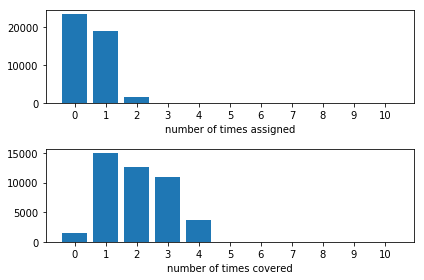

In [23]:
subplot(211)
hist(assigned_count, 11, (-0.5, 10.5), rwidth=0.8)
xticks(np.arange(0,11))
xlabel('number of times assigned')

subplot(212)
hist(covered_count, 11, (-0.5, 10.5), rwidth=0.8)
xticks(np.arange(0,11))
xlabel('number of times covered')

tight_layout()

Why are the number of assignments so much less than the coverage?
The current fiberassign algorithm prioritizes observing more targets before
getting more observations of a previously observed target.  This is what we
want for Lyman-alpha QSOs during the main survey, but it isn't what we want
for Survey Validation (or LRGs).

**TODO** Add an option to fiberassign to give the flexibility to finish targets
before starting new ones

# Assigning a target more than once - part II

Let's repeat the `NUMOBS_MORE>1` exercise with a low density of science targets so that
they don't compete with each other so much.

In [24]:
#- QSO-like sample: low density, multiple observations per target
density = 50  #- 
targets = generate_random_targets(density, tiles)
n = len(targets)
targets['PRIORITY'] = 1000
targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
targets['DESI_TARGET'] = desi_mask.ELG
targets['OBSCONDITIONS'] = np.ones(n) * obsconditions.DARK
targets['NUMOBS_MORE'] = np.ones(n) * 4  #- THIS IS WHAT IS DIFFERENT THAN BEFORE
targets.meta['EXTNAME'] = 'MTL'
targets.write('mtl.fits', overwrite=True)

In [25]:
#- Rerun fiberassign
cleanup_output(outdir, tiles)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

0


In [26]:
assigned_ids, covered_ids = get_assigned_covered(tiles)
assigned_count = count_coverage(assigned_ids)
covered_count = count_coverage(covered_ids)

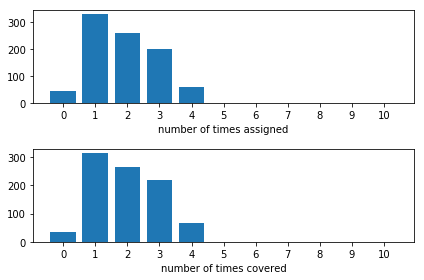

In [27]:
subplot(211)
hist(assigned_count, 11, (-0.5, 10.5), rwidth=0.8)
xticks(np.arange(0,11))
xlabel('number of times assigned')

subplot(212)
hist(covered_count, 11, (-0.5, 10.5), rwidth=0.8)
xticks(np.arange(0,11))
xlabel('number of times covered')

tight_layout()

That looks much better.  Let's confirm that the targets with low assignments are the ones with low coverage.

In [28]:
n2d = np.zeros((10, 10), dtype=int)

count_assigned = Counter(assigned_ids)
count_covered = Counter(covered_ids)

for tid in targets['TARGETID']:
    n = count_assigned[tid]
    m = count_covered[tid]
    n2d[n,m] += 1

Text(0,0.5,'Number of times Assigned')

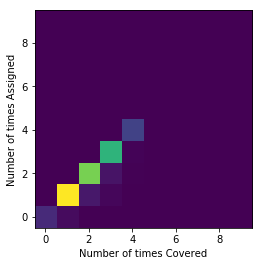

In [29]:
imshow(n2d)
xlabel('Number of times Covered')
ylabel('Number of times Assigned')

Indeed, nearly all cases of low assignments are due to low coverage

# Exercises

1. Run an intermediate density case where the number of targets times the number of requested observations is approximately equal to the total number of fibers.
2. Track down a case where a fiber received fewer than its maximum number of possible assignments based upon coverage.  Determine if the "missing" case was legitimate (e.g. if the fiber was assigned to a higher SUBPRIORITY target instead).
3. Generate an input target list with two different kinds of targets at the same density but different `PRIORITY`.  Run `fiberassign` on those and study the outputs.  Do the higher priority targets get more assigned fibers?

# TODO
* Add examples for running on real data, including using `desitarget.mtl.make_mtl` to convert targets -> mtl.
* Add examples for running on mocks.
* When running fiberassign, capture stderr/stdout to a log and print an informative error message
  if it crashes.